#  Melanoma Skin Cancer Detection

## Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In this notebook, we will build and train model to detect Melanoma

The solution is divided into the following sections:

1. Data Reading and Understanding
2. Data Preparation
3. Data Visualization
4. Model Building - CNN Model
5. Data Augmentation
6. Model Building on Augmented Data 
7. Class Distribution
8. Class Imbalance Treatment
9. Model Building on balanced data

### Importing all the important libraries

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install tensorflow-gpu

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import datetime 
import Augmentor
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7412908976540332196
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4390740009064070356
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Reading and Understanding

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Defining the path for train and test images
#C:\Users\Nazneen\Downloads\Melanoma_Assignment\CNN_Assignment\Dataset\Train
#train_path="C:/Users/Nazneen/Downloads/Melanoma_Assignment/CNN_Assignment/Dataset/Train/"
#test_path="C:/Users/Nazneen/Downloads/Melanoma_Assignment/CNN_Assignment/Dataset/Test/"
train_path="gdrive/MyDrive/CNN_Assignment/Dataset/Train/"
test_path="gdrive/MyDrive/CNN_Assignment/Dataset/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Number of Training images :',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Number of Testing images :',image_count_test)

Number of Training images : 2302
Number of Testing images : 118


This dataset has about __2357 images (2239 train , 118 test)__ of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## 2. Data Preparation

In [ ]:
#Define Batch Size , image height and width 
batch_size = 32
img_height = 180
img_width = 180

### 2.1 Train Data Set Creation <a name='no2.1' />

Use 80% of the images for training, and 20% for validation.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2302 files belonging to 9 classes.
Using 1842 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


<BarContainer object of 9 artists>

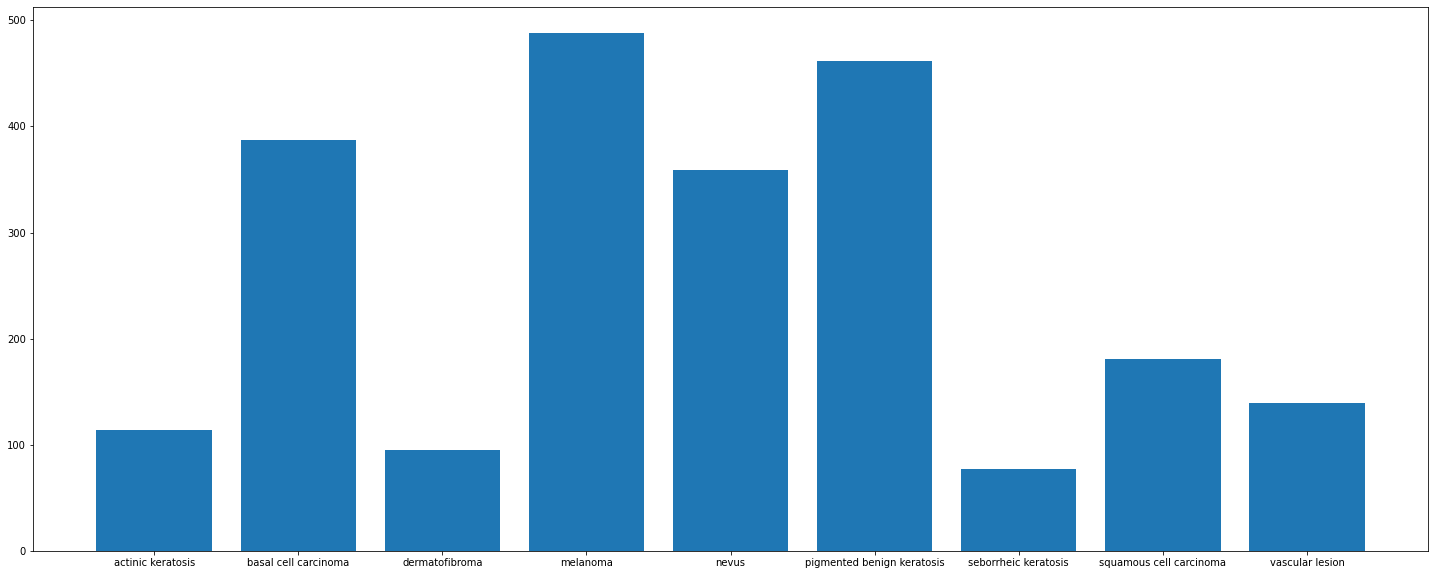

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

### 2.2 Validation Data Set Creation <a name='no2.2' />

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2302 files belonging to 9 classes.
Using 460 files for validation.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Data Visualization

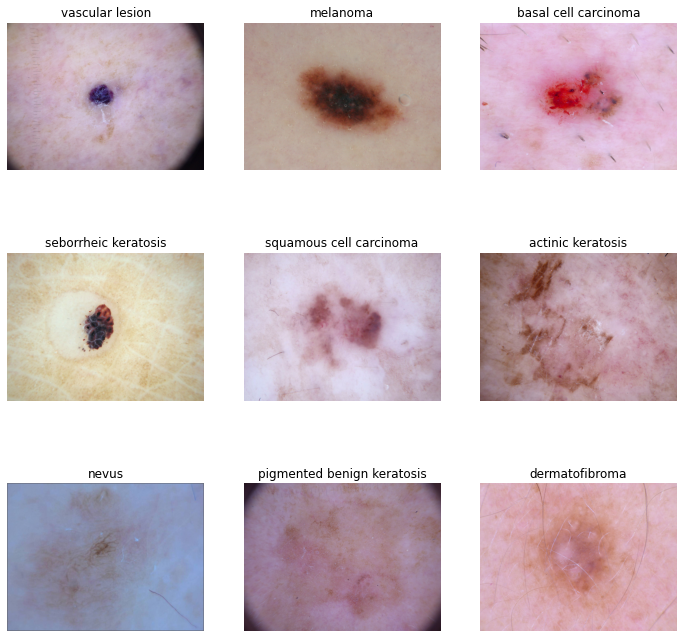

In [ ]:
plt.figure(figsize=(12, 12))
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## 4. Model Building

### 4.1 Create Model

In [ ]:
num_classes = 9

In [ ]:
initial_model =Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),  
    Dense(9, activation='softmax')
])

### 4.2 Compile Model

In [ ]:
def compileModel(model):

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [ ]:
compileModel(initial_model)

###  4.3 Train Model

In [ ]:
def trainModel(model, epochs):
  start_time= datetime.datetime.now()
  print('Start Time ----->',start_time)
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )
  end_time = datetime.datetime.now()
  print('End Time ----->',end_time)
  delta = end_time - start_time
  print('Time Taken in seconds ----> ', delta.seconds)
  return history

In [ ]:
epochs = 20
history = trainModel(initial_model, epochs)

Start Time -----> 2022-07-20 08:18:37.310946
Epoch 1/20
58/58 [==============================] - 15s 227ms/step - loss: 0.1603 - accuracy: 0.9327 - val_loss: 2.1328 - val_accuracy: 0.5370
Epoch 2/20
58/58 [==============================] - 15s 228ms/step - loss: 0.2089 - accuracy: 0.9093 - val_loss: 2.2066 - val_accuracy: 0.5283
Epoch 3/20
58/58 [==============================] - 15s 228ms/step - loss: 0.1999 - accuracy: 0.9218 - val_loss: 1.9308 - val_accuracy: 0.5457
Epoch 4/20
58/58 [==============================] - 15s 225ms/step - loss: 0.2413 - accuracy: 0.9072 - val_loss: 2.3790 - val_accuracy: 0.5022
Epoch 5/20
58/58 [==============================] - 15s 236ms/step - loss: 0.1993 - accuracy: 0.9121 - val_loss: 2.0368 - val_accuracy: 0.5391
Epoch 6/20
58/58 [==============================] - 15s 231ms/step - loss: 0.1747 - accuracy: 0.9213 - val_loss: 2.5852 - val_accuracy: 0.5043
Epoch 7/20
58/58 [==============================] - 15s 232ms/step - loss: 0.1460 - accuracy: 0.9

In [ ]:
# View the summary of all layers
def showSummary(model): 
  model.summary()
  return

In [ ]:
showSummary(initial_model)

NameError: ignored

###  4.4 Visualize the results

In [ ]:
def compareAccuracyAndLoss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  return

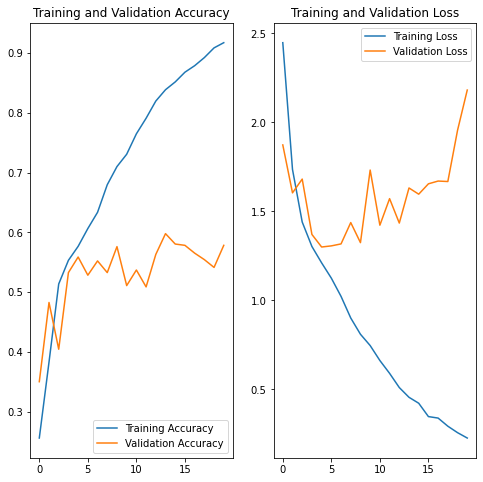

In [ ]:
compareAccuracyAndLoss(history)

###  4.5 Observations <a name='no4.5' />

-  The accuracy of the model for the **Training data set** is at **67.75%**. However, the **Validation accuracy** is not at par with the training accuracy. 
-  It is only at **47.65%**. Also,the validation loss as observed is very high.
-  This could also be an indicator of **Overfitting** in the model.
-  We could add some `Dropout` layers and remove the `BatchNormalization` layers. 
-  And by adding a few more layers, we could improve the accuracy by trying to extract more features.

In [ ]:
updated_model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,), 
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5),    
    Dense(9, activation='softmax')
])

In [ ]:
compileModel(updated_model)

In [ ]:
epochs = 20 
history = trainModel(updated_model, epochs)

Start Time -----> 2022-07-20 09:58:54.190109
Epoch 1/20
58/58 [==============================] - 5s 94ms/step - loss: 1.2208 - accuracy: 0.5662 - val_loss: 1.3050 - val_accuracy: 0.5500
Epoch 2/20
58/58 [==============================] - 5s 93ms/step - loss: 1.1980 - accuracy: 0.5619 - val_loss: 1.3341 - val_accuracy: 0.5348
Epoch 3/20
58/58 [==============================] - 5s 93ms/step - loss: 1.1867 - accuracy: 0.5760 - val_loss: 1.3769 - val_accuracy: 0.5348
Epoch 4/20
58/58 [==============================] - 5s 92ms/step - loss: 1.2039 - accuracy: 0.5787 - val_loss: 1.3837 - val_accuracy: 0.5130
Epoch 5/20
58/58 [==============================] - 5s 92ms/step - loss: 1.1456 - accuracy: 0.5765 - val_loss: 1.2993 - val_accuracy: 0.5522
Epoch 6/20
58/58 [==============================] - 5s 92ms/step - loss: 1.1192 - accuracy: 0.5977 - val_loss: 1.3487 - val_accuracy: 0.5500
Epoch 7/20
58/58 [==============================] - 5s 92ms/step - loss: 1.0300 - accuracy: 0.6183 - val_loss

In [ ]:
updated_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_35 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 89, 89, 64)        18496     
                                                     

In [ ]:
compareAccuracyAndLoss(history)

AttributeError: ignored

##  5. Data Augmentation 

###  5.1 Define the Augmentation

In [ ]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

###  5.2 Visualize the Augmented Data

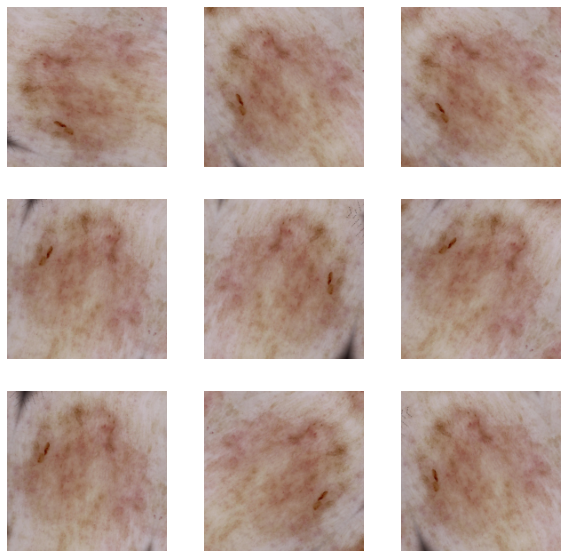

In [ ]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  aug_img=np.array(augmented_image[0],np.int32)  
  plt.imshow((aug_img))
  plt.axis("off")

## 6. Model Building on Augmented Data

###  6.1 Creating the Model <a name='no7.1' />

In [ ]:
augmented_model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,), 
    data_augmentation,
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5),    
    Dense(9, activation='softmax')
])

### 6.2 Compiling the model

In [ ]:
compileModel(augmented_model)

### 6.3 Training the model

In [ ]:
epochs = 20
history = trainModel(augmented_model, epochs)

Start Time -----> 2022-07-20 10:23:01.272912
Epoch 1/20
58/58 [==============================] - 7s 103ms/step - loss: 2.1076 - accuracy: 0.1971 - val_loss: 2.1376 - val_accuracy: 0.1587
Epoch 2/20
58/58 [==============================] - 6s 102ms/step - loss: 1.8237 - accuracy: 0.3404 - val_loss: 2.2007 - val_accuracy: 0.1587
Epoch 3/20
58/58 [==============================] - 6s 103ms/step - loss: 1.7333 - accuracy: 0.3849 - val_loss: 2.2954 - val_accuracy: 0.1587
Epoch 4/20
58/58 [==============================] - 6s 101ms/step - loss: 1.6524 - accuracy: 0.4077 - val_loss: 2.3585 - val_accuracy: 0.1587
Epoch 5/20
58/58 [==============================] - 6s 100ms/step - loss: 1.6334 - accuracy: 0.4392 - val_loss: 2.4434 - val_accuracy: 0.1587
Epoch 6/20
58/58 [==============================] - 6s 100ms/step - loss: 1.6209 - accuracy: 0.4327 - val_loss: 2.1003 - val_accuracy: 0.1717
Epoch 7/20
58/58 [==============================] - 6s 100ms/step - loss: 1.5850 - accuracy: 0.4435 - v

### 6.4 Visualizing the results

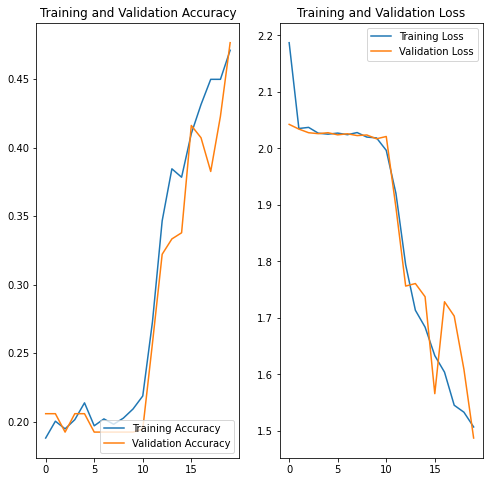

In [ ]:
compareAccuracyAndLoss(history)

### 6.5  Observations 

-  The model accuracy for **Train data set** has gone up to nearly **48%**.
-  The accuracy for the **Validation set** is also at **48%**.
-  This is a much better model compared to the previous two models as there seems to be **No Overfit** with the training accuracy **48%** and validation accuracy at **48%**.
-  `Data Augmentation` has improved the model performance.

## 7. Check Class Imbalance

In [ ]:
for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 387 samples.
dermatofibroma has 95 samples.
melanoma has 488 samples.
nevus has 359 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


In [ ]:
#TODO plot

-  The samples of various classes are not in equal proportion.
-  There is a significant **Class Imbalance** observed.
-  The class with the least number of samples is `Seborrheic Keratosis` with **77**.
-  The class that dominates the data in terms of proportionate number of samples is `Pigmented Benign Keratosis` with sample size of **462**. 

## 7. Class Imbalance Treatment

### 7.1 Using Augmentor 

In [ ]:
path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FEAA4DD1310>: 100%|██████████| 500/500 [00:18<00:00, 27.74 Samples/s]


Initialised with 387 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEAA4DEA690>: 100%|██████████| 500/500 [00:19<00:00, 25.45 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEAA4DB4C90>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 488 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FEAA432CD50>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 359 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FEAA4E86D90>: 100%|██████████| 500/500 [01:22<00:00,  6.08 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEAA424D810>: 100%|██████████| 500/500 [00:18<00:00, 27.00 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FEB4E13FE90>: 100%|██████████| 500/500 [00:41<00:00, 12.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB7A0D4E50>: 100%|██████████| 500/500 [00:17<00:00, 27.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/CNN_Assignment/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FEB6099B550>: 100%|██████████| 500/500 [00:20<00:00, 24.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
for i in class_names:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 887 samples.
dermatofibroma has 595 samples.
melanoma has 988 samples.
nevus has 859 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


In [ ]:
#TODO plot

### 7.3 Observations <a name='no9.3' />

-  The Augmentor has **helped decrease the imbalance** in class images and that can be viewed from above.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##  8. Model Building on Balanced Dataset

### 8.1 Create Train and Validation Dataset

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6802 files belonging to 9 classes.
Using 5442 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6802 files belonging to 9 classes.
Using 1360 files for validation.


### 8.2 Create Model

In [ ]:
final_model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5),    
    Dense(9, activation='softmax')
])

### 8.3 Compile Model

In [ ]:
compileModel(final_model)

### 8.4 Train the Model

In [ ]:
epochs = 30
history = trainModel(final_model, epochs)

Start Time -----> 2022-07-20 10:42:23.552939
Epoch 1/30
171/171 [==============================] - 37s 205ms/step - loss: 2.0658 - accuracy: 0.2269 - val_loss: 2.5478 - val_accuracy: 0.1382
Epoch 2/30
171/171 [==============================] - 34s 191ms/step - loss: 1.7887 - accuracy: 0.2878 - val_loss: 2.3654 - val_accuracy: 0.1169
Epoch 3/30
171/171 [==============================] - 34s 192ms/step - loss: 1.7308 - accuracy: 0.3155 - val_loss: 2.2452 - val_accuracy: 0.2015
Epoch 4/30
171/171 [==============================] - 34s 190ms/step - loss: 1.6077 - accuracy: 0.3723 - val_loss: 1.8025 - val_accuracy: 0.3022
Epoch 6/30
171/171 [==============================] - 34s 192ms/step - loss: 1.4726 - accuracy: 0.4485 - val_loss: 1.4928 - val_accuracy: 0.4265
Epoch 7/30
171/171 [==============================] - 34s 192ms/step - loss: 1.3844 - accuracy: 0.4851 - val_loss: 1.3135 - val_accuracy: 0.4838
Epoch 8/30
171/171 [==============================] - 36s 201ms/step - loss: 1.2536 -

In [ ]:
showSummary(final_model)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_70 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_71 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 89, 89, 32)      

###  8.5 Visualize the model results 

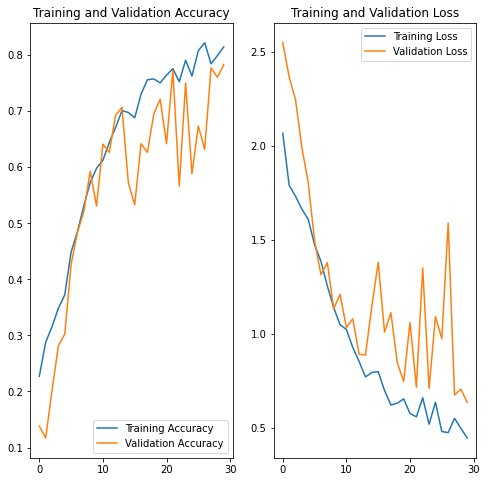

In [ ]:
compareAccuracyAndLoss(history)

### 8.6 Observations 

-  The training accuracy seems to be nearly **~90%**. 
-  The validation accuracy is nearly **~80%**.
-  Though the model accuracy has improved, the **class rebalance** has helped **treat the overfitting to some extent**.
-  Much better models could be built or tried out using **more epochs and more layers**.